## Vars ##

In [1]:
from pathlib import Path

path = Path('./project_vars.py')
is_file_exist = path.is_file()

if is_file_exist:
    import project_vars

is_write_to_results = False if not is_file_exist else project_vars.is_write_to_results
save_itermidiate_results = False if not is_file_exist else project_vars.save_itermidiate_results

if is_write_to_results:
    import results as r

def write_to_results(scores: float):
    if is_write_to_results:
        print(r.result(scores, 'data/results.json'))
    else:
        print(scores)

## Imports and Configuration ##

In [2]:
import warnings

import matplotlib as mpt
import category_encoders as ce
import xgboost as xgb
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from pandas.core.frame import DataFrame
from category_encoders import MEstimateEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,OrdinalEncoder,OneHotEncoder
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

print('pandas')
print(pd.__version__)
print('sklearn')
print(skl.__version__)
print('xgboost')
print(xgb.__version__)
print('category_encoders')
print(ce.__version__)
print('seaborn')
print(sns.__version__)
print('matplotlib')
print(mpt.__version__)


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')

y_column_name = 'SalePrice'

def to_dataframe(index, columns):
    return FunctionTransformer(lambda X: pd.DataFrame(X, index=index, columns=columns))

path = Path('./vars.py')

print(path.is_file())


Python version
3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=11, micro=0, releaselevel='final', serial=0)
pandas
1.5.3
sklearn
1.2.1
xgboost
1.7.3
category_encoders
2.6.0
seaborn
0.12.2
matplotlib
3.7.0
False


C:\Users\annDo\AppData\Local\Temp\ipykernel_9588\3293080384.py:49: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Load data ##

In [3]:
data_dir = Path("../input/house-prices-advanced-regression-techniques/")
df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
# Merge the splits so we can process them together
df_in_raw = pd.concat([df_train, df_test])


## Score dataset ##

In [4]:
def score_dataset(X, y, model=XGBRegressor(), n_jobs=None, fit_params=None):
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=n_jobs,
        fit_params=fit_params,
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


## Preprocess data ##

### Remove outliners ###

In [5]:
df_in = df_in_raw[df_in_raw.LotArea < 100000]
df_train = df_train[df_train.LotArea < 100000]


### Transform PoolQC ###

In [6]:
PoolQC = df_in[['PoolQC']]
df_in['IsPoolExist'] = PoolQC.notna().astype(int)

### Transforme Alley ##

In [7]:
Alley = df_in[['Alley']]
df_in['IsAlleyExist'] = Alley.notna().astype(int)

### Transforme Fence ###

In [8]:
Fence = df_in[['Fence']]
df_in['IsFenceExist'] = Fence.notna().astype(int)

### Remove useless ###

In [9]:
removed_columns = [
    'YrSold',
    'MoSold',
    'Utilities',
    'RoofMatl',
    '3SsnPorch',
    'MiscFeature',
    'BsmtFinSF2',
    'Condition2',
    
    'PoolQC',
    'PoolArea',
    'Alley',
]
df_in = df_in.drop(removed_columns, axis=1)


### Fix data ###

In [10]:
def clean(df: DataFrame) -> DataFrame:
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(
        df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        # "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    # df["MiscFeature"] = df["MiscFeature"].replace({"Othr": np.nan}).replace({"TenC": np.nan}).replace({"Gar2": np.nan})
    return df

df_in = clean(df_in)


### Encode nominative (unordered) categorical features ###

In [11]:
features_nominative = [
    "MSSubClass", 
    "MSZoning",
    "Street", 
    # "Alley",
    "LandContour", 
    "LotConfig",
    "Neighborhood", 
    "Condition1",
    "Condition2", 
    "BldgType",
    "HouseStyle", 
    "RoofStyle",
    "RoofMatl", 
    "Exterior1st",
    "Exterior2nd", 
    "MasVnrType",
    "Foundation", 
    "Heating",
    "GarageType",
    # "MiscFeature", 
    "SaleType",
    "SaleCondition",
    # "MiscFeature",
]

features_nominative = [item for item in features_nominative if item not in removed_columns]

one_hot_count = sum([len(df_in[column].unique())
                    for column in features_nominative]) - 1

one_hote_names = ['OH{}'.format(name) for name in range(one_hot_count)]

for name in features_nominative:
    df_in[name] = df_in[name].astype("category")

categorical_nominative_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(
        strategy='constant',
        missing_values=np.nan,
        fill_value='None')),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    # ('encoder', OrdinalEncoder(
    #     handle_unknown='use_encoded_value',
    #     unknown_value=np.nan
    # )),
])


### Encode the ordinal (ordered) categorical features ###

In [12]:
# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(1,11))

ordered_levels_int = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
}

ordered_levels_int = {key: ordered_levels_int[key] for key in ordered_levels_int.keys() if key not in removed_columns}

ordered_levels = {
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

ordered_levels = {key: ordered_levels[key] for key in ordered_levels.keys() if key not in removed_columns}

features_ordered = list(ordered_levels.keys())
features_ordered_int = list(ordered_levels_int.keys())

for name, levels in ordered_levels.items():
    df_in[name] = df_in[name].astype(CategoricalDtype(levels, ordered=True))

for name, levels in ordered_levels_int.items():
    df_in[name] = df_in[name].astype(CategoricalDtype(levels, ordered=True))

categorical_ordinal_int_transformer = Pipeline(
    steps=[
         ('imputer', SimpleImputer(
            strategy='constant',
            missing_values=np.nan,
            fill_value=0)),
        ('encoder', OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ]
)

categorical_ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(
            strategy='constant',
            missing_values=np.nan,
            fill_value='None')),
        ('encoder', OrdinalEncoder(
            handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ]
)


### Numerical data transform ###

In [13]:
features_num = list(
    df_in.select_dtypes(include=np.number)
    .columns
    .difference([y_column_name])
    )

print(list(features_num))

numerical_constant_transformer = Pipeline(steps=[
    ('imputer_constant', SimpleImputer(strategy='constant', fill_value=0,
     missing_values=np.nan)),
])

len(features_num)


['BedroomAbvGr', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FirstFlrSF', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'IsAlleyExist', 'IsFenceExist', 'IsPoolExist', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'ScreenPorch', 'SecondFlrSF', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd']


31

## Setup pipeline ##

In [14]:
column_transformer = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ('num_constant', numerical_constant_transformer, features_num),
        ('cat_nominative', categorical_nominative_transformer, features_nominative),
        ('cat_ordered', categorical_ordinal_transformer, features_ordered),
        ('cat_ordered_int', categorical_ordinal_int_transformer, features_ordered_int),
        ('price', 'passthrough', [y_column_name]),
    ], verbose=True)


transform_pipeline = Pipeline(steps=[
    ('encode', column_transformer),
    ('dataframe', to_dataframe(df_in.index,
                               features_num +
                               one_hote_names +
                            #    features_nominative +
                               features_ordered +
                               features_ordered_int +
                               [y_column_name]
                               )),
], verbose=True)

transformed_df = transform_pipeline.fit_transform(df_in)


df_train = transformed_df.loc[df_train.index, :]
df_test = transformed_df.loc[df_test.index, :]

y: DataFrame = df_train.pop('SalePrice')
X: DataFrame = df_train

if save_itermidiate_results:
    y.to_csv('data/y.csv')
    X.to_csv('data/X.csv')

df_test.pop('SalePrice')
X_test = df_test


[ColumnTransformer] .. (1 of 5) Processing num_constant, total=   0.0s
[ColumnTransformer]  (2 of 5) Processing cat_nominative, total=   0.0s
[ColumnTransformer] ... (3 of 5) Processing cat_ordered, total=   0.0s
[ColumnTransformer]  (4 of 5) Processing cat_ordered_int, total=   0.0s
[ColumnTransformer] ......... (5 of 5) Processing price, total=   0.0s
[Pipeline] ............ (step 1 of 2) Processing encode, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing dataframe, total=   0.0s


## XGBRegressor params ##

In [15]:
max_n_estimators = 20000
xgb_params = {
    # "colsample_bylevel": 0.3874941751507784,
    # "colsample_bynode": 0.5619050645629974,
    # "colsample_bytree": 0.7664751627840607,
    # "eta": 0.8923067850311843,
    
    # "max_depth": 4,
    # "min_child_weight": 3,
    # "reg_alpha": 0.0077501013720934625,
    # "reg_lambda": 0.9819773887231251,
    # "subsample": 0.5597482197496666,
    # "gamma": 0,
    "learning_rate": 0.006,
    "predictor": "cpu_predictor",
    "num_parallel_tree": 1,
    "n_estimators": max_n_estimators
}


## Early stop ##

[0]	validation_0-rmsle:5.12141	validation_1-rmsle:5.12161
[1]	validation_0-rmsle:4.43200	validation_1-rmsle:4.43293
[2]	validation_0-rmsle:4.02987	validation_1-rmsle:4.03095
[3]	validation_0-rmsle:3.74566	validation_1-rmsle:3.74679
[4]	validation_0-rmsle:3.52526	validation_1-rmsle:3.52620
[5]	validation_0-rmsle:3.34642	validation_1-rmsle:3.34745
[6]	validation_0-rmsle:3.19465	validation_1-rmsle:3.19631
[7]	validation_0-rmsle:3.06402	validation_1-rmsle:3.06634
[8]	validation_0-rmsle:2.94906	validation_1-rmsle:2.95166
[9]	validation_0-rmsle:2.84676	validation_1-rmsle:2.84956
[10]	validation_0-rmsle:2.75447	validation_1-rmsle:2.75733
[11]	validation_0-rmsle:2.67055	validation_1-rmsle:2.67362
[12]	validation_0-rmsle:2.59357	validation_1-rmsle:2.59692
[13]	validation_0-rmsle:2.52234	validation_1-rmsle:2.52531
[14]	validation_0-rmsle:2.45649	validation_1-rmsle:2.45959
[15]	validation_0-rmsle:2.39485	validation_1-rmsle:2.39751
[16]	validation_0-rmsle:2.33743	validation_1-rmsle:2.34046
[17]	va

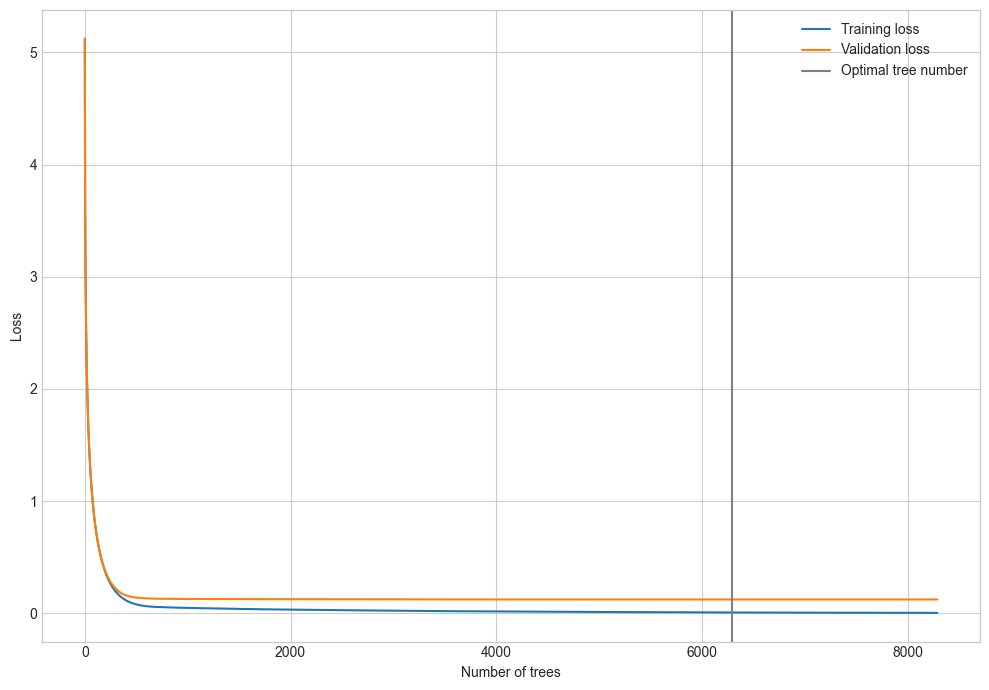

In [21]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.25)

model = XGBRegressor(random_state=0, nthread=9, **xgb_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_validation, y_validation)],
    eval_metric='rmsle',
    early_stopping_rounds=max_n_estimators*0.1,
)

results = model.evals_result()
training_loss: list[float] = results['validation_0']['rmsle']
validation_loss: list[float] = results['validation_1']['rmsle']
min_validation_index = validation_loss.index(min(validation_loss))
training_loss[min_validation_index]
validation_loss[min_validation_index]

xgb_params['n_estimators'] = min_validation_index

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmsle"], label="Training loss")
plt.plot(results["validation_1"]["rmsle"], label="Validation loss")
plt.axvline(min_validation_index, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")

plt.legend()


## Setup model ##

In [17]:
scores = score_dataset(
    X, y,
    model=model,
)

write_to_results(scores)


{'prev': 0.12618792017056915, 'curr': 0.12618792017056915, 'best': 0.11301070061235105}


# Train Model and Create Submissions #

In [18]:
xgb = XGBRegressor(random_state=0, nthread=9,**xgb_params)
xgb.fit(X, np.log(y))
predictions = np.exp(xgb.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)

print("Your submission was successfully saved!")


Your submission was successfully saved!
